In [1]:
# Update sklearn to prevent version mismatches
!pip install sklearn --upgrade
# install joblib. This will be used to save your model. 
# Restart your kernel after installing 
!pip install joblib

This model uses a neural network and GridSearchCV to predict share price impacts of Interest changes

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_stock1 = pd.read_csv("../../static/data/CSL.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df = df_stock2.dropna()
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,RBA,FED,CPI
5746,27/07/2022,288.179993,293.299988,287.019989,291.829987,291.829987,440959.0,1.35,2.5,125.0
5747,28/07/2022,293.709991,294.190002,289.149994,291.399994,291.399994,647711.0,1.35,2.5,125.0
5748,29/07/2022,294.010010,295.290009,289.839996,289.839996,289.839996,1141755.0,1.35,2.5,125.0
5749,1/08/2022,288.649994,295.480011,288.649994,294.910004,294.910004,629744.0,1.35,2.5,125.0
5750,2/08/2022,295.209991,297.980011,293.440002,296.850006,296.850006,566982.0,1.35,2.5,125.0


In [4]:
# Connect to MongoDb
from pymongo import MongoClient
mongoClient = MongoClient()
db = mongoClient.sharesDB

df_mongo = pd.DataFrame(list(db.csl.find()))
last_val = df_mongo.iloc[-1:].values
last_date = last_val[0][1]
last_close = last_val[0][5]
print(last_val)
print(last_date,last_close)
# df_mongo.tail

[[ObjectId('62f6f762497d22f7550a51f7') '12/08/2022' 291.7200012207031
  294.0 290.4599914550781 292.8500061035156 292.8500061035156 658843.0
  1.85 2.5 125.0]]
12/08/2022 292.8500061035156


# Use `RBA`,`FED` and `CPI` for the X values

In [5]:
X = df_mongo[["RBA","FED","CPI"]]
y = df_mongo["Close"].values.reshape(-1, 1)
print(X.shape, y.shape)

(5724, 3) (5724, 1)


In [6]:
X

,RBA,FED,CPI
0,5.00,5.5,69.7
1,5.00,5.5,69.7
2,5.00,5.5,69.7
3,5.00,5.5,69.7
4,5.00,5.5,69.7
...,...,...,...
5719,1.85,2.5,125.0
5720,1.85,2.5,125.0
5721,1.85,2.5,125.0
5722,1.85,2.5,125.0


# Create a Train Test Split

In [7]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_train.info)

(4293, 3) (4293, 1)
(1431, 3) (1431, 1)
<bound method DataFrame.info of        RBA   FED    CPI
1794  6.25  5.25   86.6
4370  1.50  1.00  110.7
5501  0.10  1.25  119.7
5543  0.10  1.25  121.3
99    6.00  6.50   70.2
...    ...   ...    ...
905   4.75  1.00   79.1
5192  0.25  1.25  116.2
3980  2.00  0.25  108.0
235   6.25  6.50   73.1
5157  0.25  1.25  114.4

[4293 rows x 3 columns]>


In [8]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model

In [9]:
# Fit the model to the training data and calculate the scores for the training and testing data

### BEGIN SOLUTION
model.fit(X_train, y_train)
training_score = model.score(X_train, y_train)
testing_score = model.score(X_test, y_test)

### END SOLUTION 

print(f"Training Score: {training_score}")
print(f"Testing Score: {testing_score}")

Training Score: 0.8689218200906992
Testing Score: 0.8699571709864652


In [10]:
# X_train = X_train.reshape((X_train.shape[0], 1))

In [11]:
#Linear Regression Residual showing difference actual vs predicted
# residual = pd.DataFrame([model.predict(X_train),y_train,(model.predict(X_train)-y_train)])
# residual.tail

Text(0.5, 1.0, 'Residual Plot')

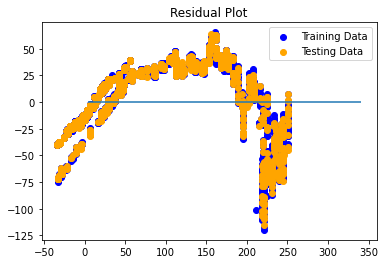

In [12]:
# Plot the Residuals for the Training and Testing data
plt.scatter(model.predict(X_train), model.predict(X_train) - y_train, c="blue", label="Training Data")
plt.scatter(model.predict(X_test), model.predict(X_test) - y_test, c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y.min(), xmax=y.max())
plt.title("Residual Plot")

In [13]:
# Linear Regression: X_test predictions to variable
predictions = model.predict(X_test)

#### R2 Score is a very popular metric used for evaluating the performance of linear regression models. Where R2 Score is between 0 and 1, the closer to 1, the better the regression fit.
#### Use MSE or MAE when comparing two or more models, the lower the value of MSE or MAE, the better. MSE (Mean Square Error): Uses Euclidean distance to calculate the error. MSE gives the magnitude of the error only.

In [14]:
# Used X_test, y_test, and model.predict(X_test) to calculate MSE and R2

### BEGIN SOLUTION
from sklearn.metrics import mean_squared_error

MSE = mean_squared_error(y_test, predictions)
r2 = model.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1098.8579899964777, R2: 0.8699571709864652


#### Lasso regression imposes a constraint on the model parameters that causes regression coefficients for some variables to shrink toward zero. It comes with a parameter, alpha , and the higher the alpha , the more feature coefficients are zero. When alpha is 0 , Lasso regression produces the same coefficients as a linear regression.

In [15]:
# LASSO model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Lasso

### BEGIN SOLUTION
lasso = Lasso(alpha=.01).fit(X_train, y_train)

predictions = lasso.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = lasso.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1098.84882270538, R2: 0.869958255876851


In [16]:
# Ridge model
# Note: Used an alpha of .01 when creating the model for this activity
from sklearn.linear_model import Ridge

### BEGIN SOLUTION
ridge = Ridge(alpha=.01).fit(X_train, y_train)

predictions = ridge.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = ridge.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1098.8579428052585, R2: 0.8699571765712448


In [17]:
# ElasticNet model
# Note: Use an alpha of .01 when creating the model for this activity
from sklearn.linear_model import ElasticNet

### BEGIN SOLUTION
elasticnet = ElasticNet(alpha=.01).fit(X_train, y_train)

predictions = elasticnet.predict(X_test)

MSE = mean_squared_error(y_test, predictions)
r2 = elasticnet.score(X_test, y_test)
### END SOLUTION

print(f"MSE: {MSE}, R2: {r2}")

MSE: 1098.7788736843634, R2: 0.8699665338969979


# Hyperparameter Tuning

In [18]:
y_target = df_mongo["Close"]
y_target.shape

(5724,)

In [19]:
# Use train_test_split to create training and testing data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_target, random_state=1)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(4293, 3) (4293,)
(1431, 3) (1431,)


In [20]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4293, 3) (4293,)
(1431, 3) (1431,)


#### GridSearchCV and RandomizedSearchCV are techniques to evaluate models for a given hyperparameter vector using cross-validation, hence the “CV” suffix of the class name.
#### We are executing many models together is to find which machine learning model works best for this particular dataset.

In [21]:
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [22]:
regressors = [
    RandomForestRegressor(),
    DecisionTreeRegressor(),
    KNeighborsRegressor(),
    GradientBoostingRegressor(),
    KNeighborsRegressor(),
    ExtraTreesRegressor(),
    LinearRegression(),
    Lasso(),
    Ridge()
]

In [23]:
from time import time
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score

head = 10
for model in regressors[:head]:
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start    
    print(model)
    print("\tTraining time: %0.3fs" % train_time)
    print("\tPrediction time: %0.3fs" % predict_time)
    print("\tExplained variance:", explained_variance_score(y_test, y_pred))
    print("\tMean absolute error:", mean_absolute_error(y_test, y_pred))
    print("\tR2 score:", r2_score(y_test, y_pred))
    print()

RandomForestRegressor()
	Training time: 0.207s
	Prediction time: 0.018s
	Explained variance: 0.9970681670701862
	Mean absolute error: 2.6891759350425435
	R2 score: 0.9970635980969123

DecisionTreeRegressor()
	Training time: 0.002s
	Prediction time: 0.001s
	Explained variance: 0.9970339634525486
	Mean absolute error: 2.698621882122019
	R2 score: 0.9970285586787248

KNeighborsRegressor()
	Training time: 0.002s
	Prediction time: 0.002s
	Explained variance: 0.996880956209252
	Mean absolute error: 2.783848976642208
	R2 score: 0.9968701350597828

GradientBoostingRegressor()
	Training time: 0.082s
	Prediction time: 0.002s
	Explained variance: 0.9965572380435436
	Mean absolute error: 3.105264300017252
	R2 score: 0.9965534626788517

KNeighborsRegressor()
	Training time: 0.002s
	Prediction time: 0.003s
	Explained variance: 0.996880956209252
	Mean absolute error: 2.783848976642208
	R2 score: 0.9968701350597828

ExtraTreesRegressor()
	Training time: 0.119s
	Prediction time: 0.016s
	Explained varia

#### By comparing these results, we can quickly see that RandomForestRegressor and DecisionTreeRegressor are the best models for our data
#### Machine learning models have parameters, which are the internal coefficients set by training or optimizing the model on a training dataset.
#### Parameters are different from hyperparameters. Parameters are learned automatically; hyperparameters are set manually to help guide the learning process.

In [24]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(random_state = 42)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())

Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [25]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [26]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [27]:
rf_random.best_params_

{'n_estimators': 1600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': True}

In [28]:
def evaluate(model, X_test, y_test):
    predictions = model.predict(X_test)
    errors = abs(predictions - y_test)
    mape = 100 * np.mean(errors / y_test)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))

Model Performance
Average Error: 2.7160 degrees.
Accuracy = 96.14%.
Model Performance
Average Error: 2.6926 degrees.
Accuracy = 96.17%.
Improvement of 0.02%.


In [29]:
# Hyperparameter tuning has not improved accuracy significantly

In [30]:
model_rfr = RandomForestRegressor()
model_rfr.fit(X_train, y_train)
y_test_pred = model_rfr.predict(X_test)
y_test_pred

array([ 32.71736599,   6.27042004, 170.97969845, ...,   4.85086581,
        12.19232448,  29.44464192])

In [31]:
#RandomForestRegressor Residual showing difference actual vs predicted
residual_dtr = pd.DataFrame([model_rfr.predict(X_train),y_train,(model_rfr.predict(X_train)-y_train)])
residual_dtr.tail

<bound method NDFrame.tail of         0           1           2           3         4           5     \
0  22.350928  130.366778  298.264265  299.074128  8.773880  235.391989   
1  23.143333  128.460007  312.010010  317.059998  7.033333  234.820007   
2  -0.792405    1.906771  -13.745745  -17.985870  1.740547    0.571982   

        6          7          8         9     ...        4283       4284  \
0  32.657573  12.043552  34.906844  7.546468  ...  107.380946  11.317440   
1  33.349998  11.956666  35.110001  7.500000  ...  100.059998  11.333333   
2  -0.692425   0.086886  -0.203157  0.046468  ...    7.320948  -0.015893   

         4285       4286       4287      4288        4289       4290  \
0  273.781617  34.307251  35.488959  4.850866  285.495709  91.552290   
1  278.640015  32.720001  34.650002  4.466666  280.750000  90.669998   
2   -4.858398   1.587250   0.838957  0.384200    4.745709   0.882292   

        4291        4292  
0  12.063997  300.233273  
1  12.033333  300.959991 

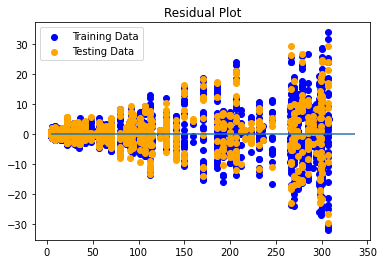

In [32]:
# Make predictions using fitted model
predictions1 = model_rfr.predict(X_test)

# Plotted the difference between the model predicted values and actual y values, versus the model predicted values
plt.scatter(model_rfr.predict(X_train), y_train - model_rfr.predict(X_train), c="blue", label="Training Data")
plt.scatter(model_rfr.predict(X_test), y_test - model_rfr.predict(X_test), c="orange", label="Testing Data")
plt.legend()
plt.hlines(y=0, xmin=y_test.min(), xmax=y_test.max())
plt.title("Residual Plot")
plt.show()

# Save the Model

In [33]:
import pickle
filename = '../../static/csl_model_rfr.sav'
pickle.dump(model, open(filename, 'wb'))
model_in_rfr = pickle.load(open(filename, 'rb'))

In [34]:
# from joblib import dump,load
# model_in_rfr = load('CSL_model_rfr.sav')

In [35]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
input =40
rfr=[]

def randomforest(rba,fed,cpi):
    for i in range(0,input):
      rfr.append([rba,fed,cpi])
      np.round_(rfr,2,out = None) 
      df = pd.DataFrame(rfr, columns = ['RBA','FED',"CPI"])
      df.round(2)
      pred_rf=model_in_rfr.predict(df)
      df['Prediction'] = pred_rf
      df['Prediction'] = df['Prediction'].astype(float).round(2)
      rba+=0.01
      fed+=0.01
      cpi+=0.01
      
    my_rforest = df.to_dict(orient='records')
    for dict_value in my_rforest:
      for k, v in dict_value.items():
        dict_value[k] = round(v, 2)
    return my_rforest,df
# print(my_rforest)
my_rf,df = randomforest(rba,fed,cpi)
# print(my_rf)
print(df)


     RBA   FED     CPI  Prediction
0   0.85  1.75  125.00      244.80
1   0.86  1.76  125.01      244.75
2   0.87  1.77  125.02      244.69
3   0.88  1.78  125.03      244.64
4   0.89  1.79  125.04      244.59
5   0.90  1.80  125.05      244.54
6   0.91  1.81  125.06      244.48
7   0.92  1.82  125.07      244.43
8   0.93  1.83  125.08      244.38
9   0.94  1.84  125.09      244.32
10  0.95  1.85  125.10      244.27
11  0.96  1.86  125.11      244.22
12  0.97  1.87  125.12      244.17
13  0.98  1.88  125.13      244.11
14  0.99  1.89  125.14      244.06
15  1.00  1.90  125.15      244.01
16  1.01  1.91  125.16      243.95
17  1.02  1.92  125.17      243.90
18  1.03  1.93  125.18      243.85
19  1.04  1.94  125.19      243.79
20  1.05  1.95  125.20      243.74
21  1.06  1.96  125.21      243.69
22  1.07  1.97  125.22      243.64
23  1.08  1.98  125.23      243.58
24  1.09  1.99  125.24      243.53
25  1.10  2.00  125.25      243.48
26  1.11  2.01  125.26      243.42
27  1.12  2.02  125.

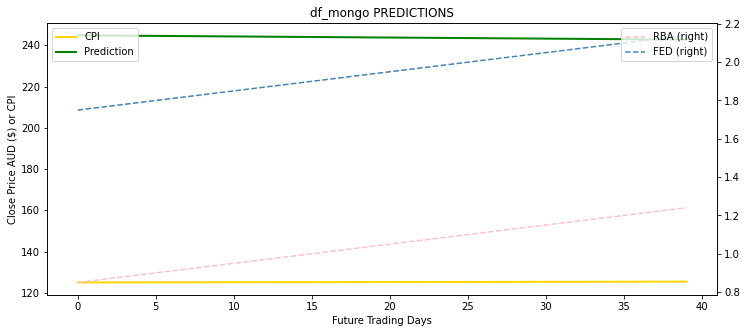

In [36]:
# DRAW THE PREDICTION
#Append the input amount of trading days to dates dictionary
input=40
# df_pred = df.iloc[0:(input-1)]
plot1 = df.plot(y=['CPI','Prediction'], figsize=(12, 5),color=['gold','green'],linewidth=2)
plot2 = df.plot(y=['RBA','FED'],secondary_y=True, ax=plot1,color=['pink','steelblue'],linestyle='dashed')
plt.title('df_mongo PREDICTIONS')
plot1.set_xlabel('Future Trading Days', fontsize=10)
plot1.set_ylabel('Close Price AUD ($) or CPI', fontsize=10)
plot1.legend(loc='upper left')
plot2.legend(loc='upper right')
plt.savefig('../../static/data/images/csl_rfr_pred.png', bbox_inches="tight")
plt.show()

In [37]:
rba = float(0.85)
fed = float(1.75)
cpi = float(125.00)
def rforest(rba,fed,cpi):
    dtr =[[rba,fed,cpi]]
    df = pd.DataFrame (dtr, columns = ['RBA','FED',"CPI"])
    pred_dtr=model_in_rfr.predict(df)
    df['Prediction'] = pred_dtr
    print(df)
    df_dict = df.to_dict(orient='records')
    return pred_dtr
Pred_rf = rforest(rba,fed,cpi)
print(Pred_rf)

    RBA   FED    CPI  Prediction
0  0.85  1.75  125.0  244.800001
[244.80000122]


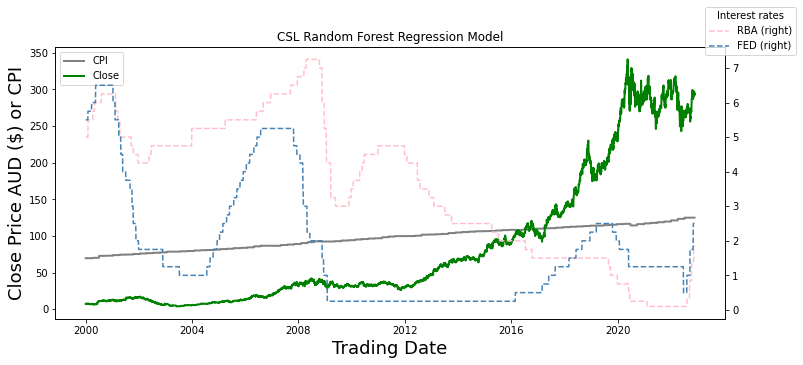

In [38]:
x = np.arange(2000,2024,4)
ax = df_mongo.plot(y=["CPI","Close"], figsize=(12, 5),color=['grey','green'],linewidth=2)
df_mongo.plot(y=["RBA","FED"],secondary_y=True, ax=ax,color=['pink','steelblue'],linestyle='dashed')
plt.legend(bbox_to_anchor=(1.03, 1), loc='upper left', borderaxespad=-4, title="Interest rates")
ax.legend(loc='upper left')
ax.set_xticks([0,1000,2000,3000,4000,5000])
ax.set_xticklabels(x, rotation=0)
ax.set_title('CSL Random Forest Regression Model')
ax.set_xlabel('Trading Date', fontsize=18)
ax.set_ylabel('Close Price AUD ($) or CPI', fontsize=18)
plt.savefig('../../static/data/images/CSL_tree.png')

#Save predicted error to MongoDB

In [39]:
# Module used to connect Python with MongoDb
import pymongo

In [40]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

name = 'CSL'

In [41]:
# query the companys collection
companys = db.find({'model': 'RFR','name': name})
# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62f22c95de6741ddbc13f568'), 'model': 'RFR', 'name': 'CSL', 'date': '09/08/2022', 'predicted': 242, 'actual': 294, 'difference': -51.0022, 'accuracy': 96.19}


In [42]:
#save last price actual to variable
actual_price = df_mongo.iloc[-1,4]
actual_date = df_mongo.iloc[-1,1] 
actual_price = int(actual_price)
base_accuracy=round(base_accuracy,2)
print(actual_price,actual_date,base_accuracy)


290 12/08/2022 96.14


In [43]:
# Set keys and values of company

predicted = int(Pred_rf)
difference = Pred_rf-actual_price
difference=difference[0]
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}, accuracy {base_accuracy}')

date 12/08/2022,predicted 244,actual 290, difference -45.19999878354716, accuracy 96.14


In [44]:
# Delete a document from a collection
db.delete_one(
    {'model': 'RFR','name': name}
)


In [45]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'RFR',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'difference': round(difference,4),
      'accuracy': base_accuracy       
    }
)

# query the classroom collection
companys = db.find({'model': 'RFR','name': name})

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62f77b21e02817947b886fcd'), 'model': 'RFR', 'name': 'CSL', 'date': '12/08/2022', 'predicted': 244, 'actual': 290, 'difference': -45.2, 'accuracy': 96.14}
